In [91]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable

In [92]:
# https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000


In [95]:
batch_size = 16
learning_rate = 3e-3
num_epochs = 30


In [96]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize(64),
        transforms.RandomResizedCrop(64,scale=(0.42,1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(64),
        transforms.RandomResizedCrop(64,scale=(0.42,1.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
}


data_sets = {
    'train': datasets.ImageFolder(root='./data/imagenet-mini/train', transform=data_transforms['train']),
    'test': datasets.ImageFolder(root='./data/imagenet-mini/val', transform=data_transforms['test'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(data_sets['train'],
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(data_sets['test'],
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0)
}


In [98]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

print(device)


cuda


In [99]:

import random


class PermuteAdaptiveInstanceNorm2d(nn.Module):
    def __init__(self, p=0.01, eps=1e-5):
        super(PermuteAdaptiveInstanceNorm2d, self).__init__()
        self.p = p
        self.eps = eps

    def forward(self, x):
        permute = random.random() < self.p
        if permute and self.training:
            perm_indices = torch.randperm(x.size()[0])
        else:
            return x
        size = x.size()
        N, C, H, W = size
        if (H, W) == (1, 1):
            
            return x
        return adaptive_instance_normalization(x, x[perm_indices], self.eps)

    def extra_repr(self) -> str:
        return 'p={}'.format(
            self.p
        )


def calc_mean_std(feat, eps=1e-5):
    size = feat.size()
    assert (len(size) == 4)
    N, C, H, W = size
    feat_std = torch.sqrt(feat.view(N, C, -1).var(dim=2).view(N, C, 1, 1) + eps)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std


def adaptive_instance_normalization(content_feat, style_feat, eps=1e-5):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat.detach(), eps)
    content_mean, content_std = calc_mean_std(content_feat, eps)
    content_std = content_std + eps  # to avoid division by 0
    normalized_feat = (content_feat - content_mean.expand(
        size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)


In [100]:

class BasicBlock(nn.Module):
    
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
       
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output


def resnet50():
    
    return ResNet(BottleNeck, [3, 4, 6, 3])


In [101]:
model = resnet50()

model = model.cuda() if use_cuda else model
    
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1024)
model.fc = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 1024),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 256),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 128),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, len(data_sets['train'].classes))
)

model.fc = model.fc.cuda() if use_cuda else model.fc

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [102]:
train_acces, test_acces = [], []
train_losses, test_losses = [], []
total_step = len(dataloaders['train'])
test_loss_min = np.Inf
for epoch in range(num_epochs):
    print(f'Epoch {epoch}\n')

    network_learned = False

    for phase in ['train', 'test']:

        running_loss = 0.0
        running_corrects = 0

        if phase == 'train':
            model.train()

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):

                if use_cuda:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
  
                inputs = inputs.float()
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                
            scheduler.step()
        else:
            
            with torch.no_grad():
                model.eval()
                for inputs, labels in dataloaders[phase]:
                    if use_cuda:
                        inputs = Variable(inputs.cuda())
                        labels = Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    inputs = inputs.float()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
            network_learned = running_loss < test_loss_min
            test_loss_min = running_loss if network_learned else test_loss_min


        epoch_loss = running_loss / len(data_sets[phase])
        epoch_acc = running_corrects.double() / len(data_sets[phase])
        
        if phase == 'train':
            train_acces.append(epoch_acc)
            train_losses.append(epoch_loss)
        else:
            test_acces.append(epoch_acc)
            test_losses.append(epoch_loss)
            
    print(f'\ntrain-loss: {np.mean(train_losses):.4f}, train-acc: {train_acces[-1]:.4f}')
    print(f'test loss: {np.mean(test_losses):.4f}, test acc: {test_acces[-1]:.4f}\n')
    

Epoch 0


train-loss: 0.4304, train-acc: 0.0035
test loss: 0.4530, test acc: 0.0043

Epoch 1


train-loss: 0.4244, train-acc: 0.0061
test loss: 0.4413, test acc: 0.0054

Epoch 2


train-loss: 0.4190, train-acc: 0.0090
test loss: 0.4322, test acc: 0.0069

Epoch 3


train-loss: 0.4142, train-acc: 0.0110
test loss: 0.4247, test acc: 0.0076

Epoch 4


train-loss: 0.4100, train-acc: 0.0117
test loss: 0.4179, test acc: 0.0148

Epoch 5


train-loss: 0.4059, train-acc: 0.0157
test loss: 0.4118, test acc: 0.0143

Epoch 6


train-loss: 0.4019, train-acc: 0.0187
test loss: 0.4072, test acc: 0.0155

Epoch 7


train-loss: 0.3981, train-acc: 0.0202
test loss: 0.4026, test acc: 0.0189

Epoch 8


train-loss: 0.3947, train-acc: 0.0226
test loss: 0.3986, test acc: 0.0270

Epoch 9


train-loss: 0.3915, train-acc: 0.0273
test loss: 0.3958, test acc: 0.0250

Epoch 10


train-loss: 0.3874, train-acc: 0.0397
test loss: 0.3915, test acc: 0.0444

Epoch 11


train-loss: 0.3836, train-acc: 0.0433
test loss: 0.38

In [103]:
train_acces = [t.cpu().numpy() for t in train_acces]
test_acces = [t.cpu().numpy() for t in test_acces]


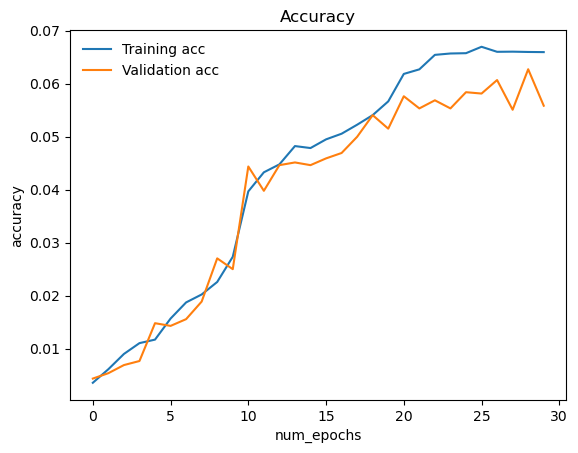

In [104]:
plt.title("Accuracy")
plt.plot(train_acces, label='Training acc')
plt.plot(test_acces, label='Validation acc')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.legend(frameon=False)


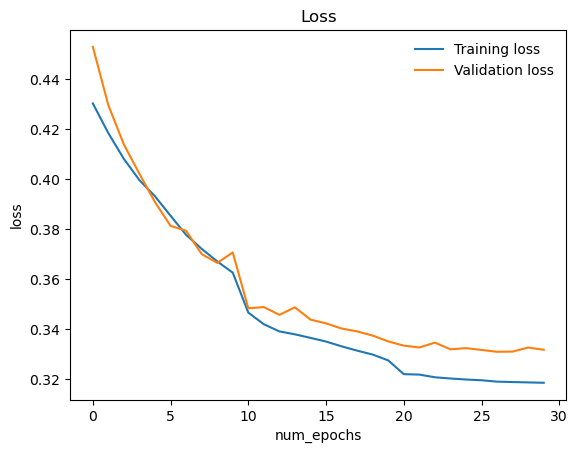

In [110]:
plt.title("Loss")
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend(frameon=False)
plt.show()


In [106]:
train_acces

[array(0.00354008),
 array(0.0061016),
 array(0.00897971),
 array(0.01102317),
 array(0.01168513),
 array(0.01565693),
 array(0.01870773),
 array(0.02020435),
 array(0.0225644),
 array(0.02731328),
 array(0.03966038),
 array(0.04325802),
 array(0.04475464),
 array(0.04820838),
 array(0.04783422),
 array(0.04947474),
 array(0.05053965),
 array(0.05223773),
 array(0.05405094),
 array(0.05664124),
 array(0.06182184),
 array(0.06268528),
 array(0.06541948),
 array(0.06567851),
 array(0.06573608),
 array(0.06694488),
 array(0.06599511),
 array(0.06602389),
 array(0.06596633),
 array(0.06593754)]

In [107]:
test_acces

[array(0.00433342),
 array(0.00535305),
 array(0.00688249),
 array(0.00764721),
 array(0.0147846),
 array(0.01427479),
 array(0.01554932),
 array(0.01886311),
 array(0.02702014),
 array(0.02498088),
 array(0.04435381),
 array(0.03976549),
 array(0.04460872),
 array(0.04511853),
 array(0.04460872),
 array(0.04588325),
 array(0.04690288),
 array(0.04996176),
 array(0.05404028),
 array(0.05149121),
 array(0.05760897),
 array(0.05531481),
 array(0.05684425),
 array(0.05531481),
 array(0.05837369),
 array(0.05811879),
 array(0.06066786),
 array(0.0550599),
 array(0.06270711),
 array(0.05582462)]

In [108]:
train_losses

[0.4303794216227919,
 0.4184605444879185,
 0.40814178222236847,
 0.3996481984789414,
 0.3931886535460082,
 0.3854151237884139,
 0.37777296503527863,
 0.37216322167792204,
 0.3671725261329764,
 0.36263385988993857,
 0.34666408764439394,
 0.34199284996672796,
 0.3391378546262031,
 0.337960202616056,
 0.3365427261085746,
 0.33507569128188286,
 0.3331599769669139,
 0.3314419390263532,
 0.3298583979708872,
 0.32753261015009993,
 0.32202981819710574,
 0.32184235672587747,
 0.32078095126073125,
 0.32028529093340674,
 0.31987847608016506,
 0.31958130307292953,
 0.31902727789802676,
 0.3188642010721033,
 0.318724262342125,
 0.3185733870167169]

In [109]:
test_losses

[0.4530401759812518,
 0.4296238725658828,
 0.4139036107604187,
 0.40215755645456347,
 0.3908591277739724,
 0.3813660785977463,
 0.37940830142711335,
 0.3700821472010441,
 0.36655744313889854,
 0.3707219488973858,
 0.34837195279493094,
 0.34886788088175946,
 0.3457681044856413,
 0.3487564655642348,
 0.34385581099193924,
 0.34234487739959724,
 0.3402777200081869,
 0.3391373594470271,
 0.33745500933841394,
 0.3351288163294271,
 0.3334280991779126,
 0.3327011304821799,
 0.3346448486142398,
 0.3319753789792339,
 0.33244032383329736,
 0.3317080159105879,
 0.33097695015900724,
 0.33105850705923,
 0.332680903859446,
 0.3317814330923414]